In [42]:
%matplotlib inline
import torch
from torch import nn
import d2l_torch as d2l
import logging
import datetime
import importlib
import rnn_base
importlib.reload(rnn_base)


<module 'rnn_base' from 'C:\\Users\\rongjoker\\PycharmProjects\\ephemeralP\\pt\\rnn_base.py'>

In [4]:
print('loading dataset imdb start: ', datetime.datetime.now())
batch_size = 128
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)
print('loading dataset imdb end:', datetime.datetime.now())

loading dataset imdb start:  2023-09-28 23:10:41.623431
loading dataset imdb end: 2023-09-28 23:14:21.045183


In [26]:
def lstm_train(lr=0.01, epochs=5):
    def init_weights(module):
        if type(module) == nn.Linear:
            nn.init.xavier_uniform_(module.weight)
        if type(module) == nn.LSTM:
            for param in module._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(module._parameters[param])

    embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
    net = rnn_base.BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

    net.apply(init_weights)
    # Loading Pretrained Word Vectors
    glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    print('embeds.shape:', embeds.shape)

    net.embedding.weight.data.copy_(embeds)
    net.embedding.weight.requires_grad = False

    # lr, num_epochs = 0.01, 5
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction="none")
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)
    torch.save(net.state_dict(), 'model/sentiment_lstm.pth')

loss 0.167, train acc 0.935, test acc 0.821
3439.6 examples/sec on [device(type='cuda', index=0)]


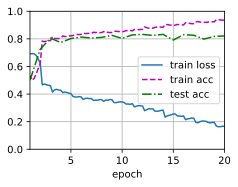

In [27]:
# batch_size = 64 读取imdb耗时3分钟半
lstm_train(epochs=20)

In [43]:
def cnn_train(lr=0.001, epochs=5):
    def init_weights(m):
        if type(m) in (nn.Linear, nn.Conv1d):
            nn.init.xavier_uniform_(m.weight)

    embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
    devices = d2l.try_all_gpus()
    net = rnn_base.TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
    net.apply(init_weights)
    # Loading Pretrained Word Vectors
    glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
    embeds = glove_embedding[vocab.idx_to_token]
    print('embeds.shape:', embeds.shape)

    net.embedding.weight.data.copy_(embeds)
    net.embedding.weight.requires_grad = False

    # lr, num_epochs = 0.01, 5
    # lr, num_epochs = 0.001, 5
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss(reduction="none")
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, epochs, devices)
    torch.save(net.state_dict(), 'model/sentiment_cnn.pth')

loss 0.119, train acc 0.956, test acc 0.854
8353.0 examples/sec on [device(type='cuda', index=0)]


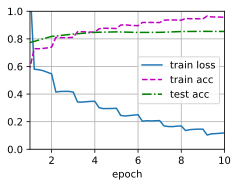

In [45]:
cnn_train(epochs=10)

In [40]:
def lstm_infer(sequence):
    print(sequence)
    embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
    model = rnn_base.BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
    model.load_state_dict(torch.load('model/sentiment_lstm.pth'))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    print(sequence.shape)
    print(sequence.reshape(1, -1).shape)
    label = torch.argmax(model(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [8]:
def cnn_infer(sequence):
    print(sequence)
    embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]
    model = rnn_base.TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
    model.load_state_dict(torch.load('model/sentiment_cnn.pth'))
    model = model.to(d2l.try_gpu())
    model.eval()  # 设置模型为推理模式
    """Predict the sentiment of a text sequence."""
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(model(sequence.reshape(1, -1)), dim=1)
    return 'positive' if label == 1 else 'negative'

In [30]:
print(lstm_infer('Exceptional storytelling and Genius Cinametography'))

Exceptional storytelling and Genius Cinametography
positive


In [31]:
print(lstm_infer('this movie is so bad'))

this movie is so bad
negative


In [28]:
print(lstm_infer("I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by "
                 "years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing "
                 "cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian "
                 "Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally "
                 "rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i "
                 "couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any "
                 "time, book your ticket and Go watch it.. NOW."))

I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any time, book your ticket and Go watch it.. NOW.
positive


In [29]:
print(lstm_infer('Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.'))

Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.
positive


In [9]:
print(cnn_infer("I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by "
                "years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing "
                "cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian "
                "Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally "
                "rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i "
                "couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any "
                "time, book your ticket and Go watch it.. NOW."))

I may consider myself lucky to be alive to watch Christopher Nolan Works which get better by years.Oppenheimer is - with no doubt-going to be one of the best movies in the history. Amazing cinematography, Exceptional acting and terrifying Soundtracks.All the cast are great from cilian Murphy who is going for the oscar with this role to Rupert Downey jr and Emily blunt and finally rami malik who has small scenes but you will never forget them.I didn't watch it in Imax as i couldn't wait and ran to the nearest cinema but now i will sure book an imax ticket.Don't waste any time, book your ticket and Go watch it.. NOW.
positive


In [10]:
print(cnn_infer('Exceptional storytelling and Genius Cinametography'))

Exceptional storytelling and Genius Cinametography
positive


In [48]:
print(cnn_infer('this movie is so bad'))

this movie is so bad
pool:AdaptiveMaxPool1d
negative


In [34]:
print(cnn_infer('Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.'))

Anything that Nolan is involved in, I will go and see, the track record is enough to get me through the doors and on that seat.
positive


In [46]:
print(cnn_infer("Whiplash is a terrific film...no doubt about that. Normally, I'd spend several paragraphs talking about how great it is except that I am the 572nd review and many people have already gone on and on about what a terrific film it is....so what can I add?! It's the 40th highest rated film on IMDb after all!"))

Whiplash is a terrific film...no doubt about that. Normally, I'd spend several paragraphs talking about how great it is except that I am the 572nd review and many people have already gone on and on about what a terrific film it is....so what can I add?! It's the 40th highest rated film on IMDb after all!
pool:AdaptiveMaxPool1d
positive


In [47]:
print(cnn_infer('This movie was far better than the trailer made it look.'))

This movie was far better than the trailer made it look.
pool:AdaptiveMaxPool1d
positive
